In [1]:
import os
import pandas as pd
#用于回测的单因子
fct=pd.read_pickle("./data/factor.pickle") #单因子值,格式为有name的pd.series
fct.dropna().tail()

date      windcode 
20230427  128140.SZ    18.829575
          128141.SZ     4.113737
          128142.SZ     4.907253
          128143.SZ    10.290646
          128144.SZ     5.070907
Name: 因子值, dtype: float64

# 回测模块导入

In [2]:
from backtest.dataframe import TradeSession, PMPandas #如果只回测的话
from backtest.base_api import event_generator #生成事件

# 需求表述

## 数据导入

In [3]:
path = r'D:\mypkgs\backtest\data_mock'
mkt=pd.read_pickle(os.path.join(path, 'cbmkt.pickle'))

cbmkt是我会定期更新的一个dataframe，里面包含可转债的交易数据（高开低收成交量成交额）及部分与回测无关的数据（债底、收盘价、YTM等，忽略即可）

可以编写函数/修改源码，并从cbmkt中提取回测所需的数据：

1.高开低收数据，在cbmkt中已包含：

In [4]:
mkt.tail()

转债余额         成交量         成交额        成交额_净价       最高价  \
date     windcode                                                               
20230508 128140.SZ  10.893835  50651100.0  94973126.6  9.476081e+07  189.8808   
         128141.SZ  12.701455  19859500.0  24853729.3  2.477592e+07  125.2152   
         128142.SZ   7.179734  40435900.0  49713314.9  4.955600e+07  123.2080   
         128143.SZ   2.439694   2969000.0   3561457.0  3.549646e+06  119.9312   
         128144.SZ   9.793808   8380000.0   9786963.7  9.774290e+06  117.0238   

                         最低价       开盘价       收盘价  
date     windcode                                 
20230508 128140.SZ  182.5808  189.8458  187.7178  
         128141.SZ  124.4972  124.5092  124.6332  
         128142.SZ  121.9110  122.8950  122.6110  
         128143.SZ  119.3032  119.7532  119.4722  
         128144.SZ  115.9748  115.9748  116.9488

2.vwap可通过成交量、成交额计算，cbmkt中二者的单位均是元，成交额是当天转债成交的市值金额、成交量是转债成交的面值金额，由于转债的面值为一张100元，因此vaap=mkt.成交额/mkt.成交量*100；

BTW: 转债应该很难获取vwapopen/vwapclose的数据，可直接假设按全天vwap成交。

In [5]:
#vwap
(mkt.成交额/mkt.成交量*100).tail()

date      windcode 
20230508  128140.SZ    187.504569
          128141.SZ    125.147810
          128142.SZ    122.943510
          128143.SZ    119.954766
          128144.SZ    116.789543
dtype: float64

3.转债暂无“当天是否停牌”的数据, 直接用成交额来管理实际能买入的量即可；

BTW:有的转债会在上市前、退市后还在cbmkt中留有数据，因此我建议直接剔除掉cbmkt中成交额=0的样本再用于回测

In [6]:
mkt1=mkt[(mkt.成交量>0)].copy()
mkt1.tail()

转债余额         成交量         成交额        成交额_净价       最高价  \
date     windcode                                                               
20230508 128140.SZ  10.893835  50651100.0  94973126.6  9.476081e+07  189.8808   
         128141.SZ  12.701455  19859500.0  24853729.3  2.477592e+07  125.2152   
         128142.SZ   7.179734  40435900.0  49713314.9  4.955600e+07  123.2080   
         128143.SZ   2.439694   2969000.0   3561457.0  3.549646e+06  119.9312   
         128144.SZ   9.793808   8380000.0   9786963.7  9.774290e+06  117.0238   

                         最低价       开盘价       收盘价  
date     windcode                                 
20230508 128140.SZ  182.5808  189.8458  187.7178  
         128141.SZ  124.4972  124.5092  124.6332  
         128142.SZ  121.9110  122.8950  122.6110  
         128143.SZ  119.3032  119.7532  119.4722  
         128144.SZ  115.9748  115.9748  116.9488

4.最后，由于转债并没有一个标准化的“距离退市日期”数据（债券有行权条款，退市日并不是确定的日期），为了防止选入即将退市的转债，有退市可能性及其它我不想选到的转债会在本地单独计算并装入变量not_include_list、再传入回测系统，请添加“不选not_include_list中的转债”的回测逻辑

not_include_list 是一个列表，以(日期,转债代码)的格式装载，表明哪些日期的哪些转债不参与回测

In [7]:
not_include_list=pd.read_pickle("./data/not_include_list.pickle")
not_include_list[-5:]

[('20230518', '128111.SZ'),
 ('20230518', '128118.SZ'),
 ('20230518', '128120.SZ'),
 ('20230518', '128122.SZ'),
 ('20230518', '128143.SZ')]

## 单因子回测

In [8]:
#用于回测的单因子
fct=pd.read_pickle("./data/factor.pickle") #单因子值,格式为有name的pd.series
fct.dropna().tail()

date      windcode 
20230427  128140.SZ    18.829575
          128141.SZ     4.113737
          128142.SZ     4.907253
          128143.SZ    10.290646
          128144.SZ     5.070907
Name: 因子值, dtype: float64

### 简单的定期选股回测

1. 回测时间段为20171229至今，策略净值的起始日为20180102，20171229的数据仅用于观察因子值排名、并确定20180102的持仓名单，严格意义上的回测是20180102至今；


2. 调仓周期为周度，假设W1、W2为连续两个自然周，W1的最后一个交易日观察因子排名，【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】，并于W2的第一个交易日开盘进行调仓与再平衡（买入在list中但未持有的转债、卖出不在list中但正持有的转债，对在list中且正持有的转债进行再平衡）；


3. 成交顺序为先卖出再买入（确保有足够多的现金）；


4. W1第一个交易日收盘时，观察实际成交的情况，可考虑将交易划分为三类：建仓、清仓、再平衡（如下图）：

    1） 对于清仓的转债，若存在未卖完的部分，第二个、第三个、第四个交易日继续卖，直到卖完为止； 若到W1的最后一个交易日收盘仍未卖完，则根据W1最后一个交易日因子值给出得list建议进行操作，若不在list中，则在W2中继续卖；若在list中，则撤出剩余的卖单，根据list建议在W2中进行买入
    
    2） 对于建仓及再平衡的转债，若剩余未成交金额<=15w，则撤单不再买入，否则在第二个、第三个、第四个交易日继续交易，直到交易完成或者本周最后一个交易日，按照更新后的持仓list进行操作
    
    
5. 回测2中情形，1）没有成交额限制（个券成交额不高于当日实际成交额的100%）；2）有成交额限制（不高于当日实际成交额的10%）


6. 交易成本的假设：按vwap成交的情况下，无需考虑冲击成本？ or 冲击成本单边1‰


7. 返回内容：策略净值、持仓/调仓记录、策略换手情况

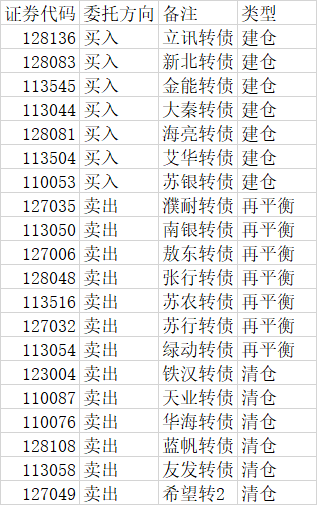

### 定期选股回测+自下而上的仓位管理

【按fct中的因子值<=0得到W2的转债持仓list(等权持有)，每期最多选30只，默认满仓，若满足条件的个券数量<30，则空出（1-N/30）的仓位】

### 定期选股回测+止盈止损事件

1. 【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】
2. 【若持仓期间W1-W2任意一个交易日，个券累计涨幅超过10%，则于次日起清仓，未成交的买单取消】；
3. 【若持仓期间W1-W2任意一个交易日，个券累计跌幅超过5%，则于次日起清仓，未成交的买单取消】；

### 定期选股回测+自下而上的仓位管理+根据因子调入调出事件

1. 【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】
2. W1-W2之间的每个交易日，观察因子排名，若当日有N只持仓个券的排名跌出了20%（不满足入选list的条件），则于次日卖出该N只个券（取消未成交的买单单），卖出个券所腾出的仓位，由当日排名最靠前（fct因子值最低）且不在list中的N只个券填充